# Import Libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Historic Data

In [72]:
DATA_URL = "https://cos-data.seattle.gov/api/views/kzjm-xkqj/rows.csv?accessType=DOWNLOAD"

print(f"Starting download and load from: {DATA_URL}")

# Read the CSV directly into a Pandas DataFrame
# The file is large, so this may take a minute or two depending on your connection.
try:
    df = pd.read_csv(DATA_URL)
    print("success")

    # Display the first 5 rows and the data types to verify the load
    print("\n--- First 5 Rows ---")
    print(df.head())

    print("\n--- DataFrame Info ---")
    df.info(verbose=False, memory_usage="deep")
    
except Exception as e:
    print(f"error: {e}")

Starting download and load from: https://cos-data.seattle.gov/api/views/kzjm-xkqj/rows.csv?accessType=DOWNLOAD
success

--- First 5 Rows ---
                 Address          Type                Datetime   Latitude  \
0             904 7th Av      Car Fire  05/22/2019 12:55:00 PM  47.606900   
1         9610 53rd Av S  Aid Response  05/22/2019 12:55:00 PM  47.515984   
2            106 Pike St  Aid Response  05/22/2019 12:57:00 PM  47.608849   
3            1902 2nd Av  Aid Response  07/01/2019 07:45:00 AM  47.610972   
4  4737 Roosevelt Way Ne      Unk Odor  07/01/2019 07:45:00 AM  47.663338   

    Longitude                Report Location Incident Number  
0 -122.329051    POINT (-122.329051 47.6069)      F190051945  
1 -122.266529  POINT (-122.266529 47.515984)      F190051946  
2 -122.339945  POINT (-122.339945 47.608849)      F190051950  
3 -122.340465  POINT (-122.340465 47.610972)      F190068848  
4 -122.317421  POINT (-122.317421 47.663338)      F190068849  

--- DataFrame Inf

## Convert Datetime column to Datetime

In [73]:
df['Datetime'] = pd.to_datetime(df['Datetime'], infer_datetime_format=True, errors='coerce')

print("dtype:", df['Datetime'].dtype)
print("nulls after conversion:", df['Datetime'].isna().sum())
print("min / max:", df['Datetime'].min(), "/", df['Datetime'].max())

dtype: datetime64[ns]
nulls after conversion: 0
min / max: 2003-11-07 09:30:48 / 2025-12-16 14:37:00


/var/folders/rv/xy89bx0176nb02txypy3fl9w0000gn/T/ipykernel_44723/1401727985.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Datetime'] = pd.to_datetime(df['Datetime'], infer_datetime_format=True, errors='coerce')


In [74]:
# select only the last 2 years of data
cutoff = pd.Timestamp.now() - pd.DateOffset(years=2)
recent_df = df[df['Datetime'] >= cutoff].copy()

print(f"Cutoff: {cutoff}")
print("Rows selected:", len(recent_df))
recent_df[['Datetime']].agg(['min', 'max'])

Cutoff: 2023-12-16 14:47:06.069871
Rows selected: 249632


,Datetime
min,2023-12-16 14:52:00
max,2025-12-16 14:37:00


In [75]:
recent_hourly = recent_df.set_index('Datetime').resample('H').size().rename('count').to_frame()
recent_hourly.head()

,count
Datetime,
2023-12-16 14:00:00,6
2023-12-16 15:00:00,13
2023-12-16 16:00:00,14
2023-12-16 17:00:00,18
2023-12-16 18:00:00,18


In [76]:
recent_daily = recent_hourly.resample('D').sum()
recent_daily.head()

,count
Datetime,
2023-12-16,161
2023-12-17,314
2023-12-18,320
2023-12-19,326
2023-12-20,354


In [77]:
df2 = df.set_index('Datetime').resample('H').size().rename('count').to_frame()
df3 = df2.resample('D').sum()
df3.head()

,count
Datetime,
2003-11-07,199
2003-11-08,254
2003-11-09,240
2003-11-10,239
2003-11-11,179


IQR summary:
 Q1=223.0, Q3=296.0, IQR=73.0
 Mild bounds: [113.5, 405.5]
 Extreme bounds: [4.0, 515.0]

Total mild outlier days: 61
Total extreme outlier days: 5

Top 10 mild outliers by deviation from median:


,count,dev_from_median
Datetime,,
2022-12-23,704,450.0
2024-01-14,662,408.0
2006-12-15,611,357.0
2024-01-15,595,341.0
2021-06-28,588,334.0
2024-11-19,496,242.0
2021-12-30,493,239.0
2024-01-13,482,228.0
2024-01-16,471,217.0


Extreme outliers (if any):


,count
Datetime,
2022-12-23,704
2024-01-14,662
2006-12-15,611
2024-01-15,595
2021-06-28,588


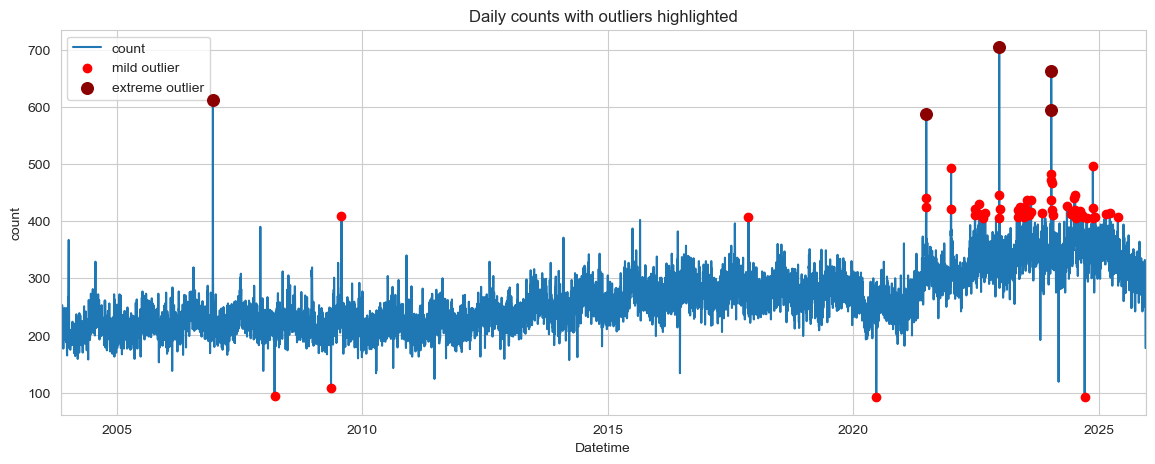

In [78]:
s = df3['count']

# IQR-based outliers (1.5*IQR for mild, 3.0*IQR for extreme)
q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1
lower_mild = q1 - 1.5 * iqr
upper_mild = q3 + 1.5 * iqr
lower_ext = q1 - 3.0 * iqr
upper_ext = q3 + 3.0 * iqr

outliers_mild = df3[(s < lower_mild) | (s > upper_mild)].copy()
outliers_extreme = df3[(s < lower_ext) | (s > upper_ext)].copy()

# Add a column showing deviation from the median for easy sorting
median = s.median()
outliers_mild['dev_from_median'] = (outliers_mild['count'] - median).abs()

# Print a short summary and top outliers
print("IQR summary:")
print(f" Q1={q1:.1f}, Q3={q3:.1f}, IQR={iqr:.1f}")
print(f" Mild bounds: [{lower_mild:.1f}, {upper_mild:.1f}]")
print(f" Extreme bounds: [{lower_ext:.1f}, {upper_ext:.1f}]")
print()
print(f"Total mild outlier days: {len(outliers_mild)}")
print(f"Total extreme outlier days: {len(outliers_extreme)}")
print()

print("Top 10 mild outliers by deviation from median:")
display(outliers_mild.sort_values('dev_from_median', ascending=False).head(10))

print("Extreme outliers (if any):")
display(outliers_extreme.sort_values('count', ascending=False))

# Plot timeseries and highlight mild/extreme outliers
ax = df3.plot(y='count', figsize=(14,5), title='Daily counts with outliers highlighted')
if not outliers_mild.empty:
    ax.scatter(outliers_mild.index, outliers_mild['count'], color='red', label='mild outlier', zorder=5)
if not outliers_extreme.empty:
    ax.scatter(outliers_extreme.index, outliers_extreme['count'], color='darkred', s=70, label='extreme outlier', zorder=6)
ax.legend()
ax.set_ylabel('count')
plt.show()

# Importing Simple Weather Data

Will be completing this after initial non-covariate implementation

# Implementing Forecasting model

In [79]:
# Take subset of importaant columns: Datetime and PK
df_prophet = df[['Datetime', 'Incident Number']].copy()
df_prophet.head()

,Datetime,Incident Number
0,2019-05-22 12:55:00,F190051945
1,2019-05-22 12:55:00,F190051946
2,2019-05-22 12:57:00,F190051950
3,2019-07-01 07:45:00,F190068848
4,2019-07-01 07:45:00,F190068849


In [80]:
# resaample to hourly frequency
df_prophet = df_prophet.set_index('Datetime').resample('H').count().reset_index()
df_prophet.columns = ['ds', 'y']  # rename columns for prophet
df_prophet.head()

,ds,y
0,2003-11-07 09:00:00,5
1,2003-11-07 10:00:00,20
2,2003-11-07 11:00:00,5
3,2003-11-07 12:00:00,17
4,2003-11-07 13:00:00,13


In [81]:
df_prophet.shape

(193806, 2)

In [82]:
pip install prophet


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [83]:
from prophet import Prophet

In [84]:
model = Prophet(
    # Set daily and weekly seasonality explicitly
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    # Prophet uses additive by default, but multiplicative can sometimes be better 
    # for count data where seasonality scales with the trend. Let's start with additive.
    seasonality_mode='additive'
)

In [85]:
model.fit(df_prophet)

14:47:13 - cmdstanpy - INFO - Chain [1] start processing
14:47:43 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
future = model.make_future_dataframe(
    periods=168, 
    freq='H', # Hourly frequency
    include_history=False # Only generate future dates
)

In [87]:
forecast = model.predict(future)

In [88]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(30))

                    ds       yhat  yhat_lower  yhat_upper
0  2025-12-16 15:00:00  17.806929   13.190741   22.776125
1  2025-12-16 16:00:00  17.840805   12.479210   22.583393
2  2025-12-16 17:00:00  17.807867   12.748630   22.589723
3  2025-12-16 18:00:00  17.603706   12.619641   22.480288
4  2025-12-16 19:00:00  17.092745   12.434568   21.801538
5  2025-12-16 20:00:00  16.232548   11.474527   21.056958
6  2025-12-16 21:00:00  15.150635   10.355382   20.072164
7  2025-12-16 22:00:00  14.074284    9.309218   18.897729
8  2025-12-16 23:00:00  13.153552    8.309456   17.851322
9  2025-12-17 00:00:00  12.340373    7.735947   17.197413
10 2025-12-17 01:00:00  11.457705    6.325273   15.742280
11 2025-12-17 02:00:00  10.421429    5.513694   15.158828
12 2025-12-17 03:00:00   9.420185    4.337787   13.838607
13 2025-12-17 04:00:00   8.871642    3.877755   13.799966
14 2025-12-17 05:00:00   9.159785    4.400936   13.898090
15 2025-12-17 06:00:00  10.353349    5.595163   15.217997
16 2025-12-17 

/var/folders/rv/xy89bx0176nb02txypy3fl9w0000gn/T/ipykernel_44723/1913115551.py:10: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  recent_obs = df_prophet.set_index('ds').last('48H')


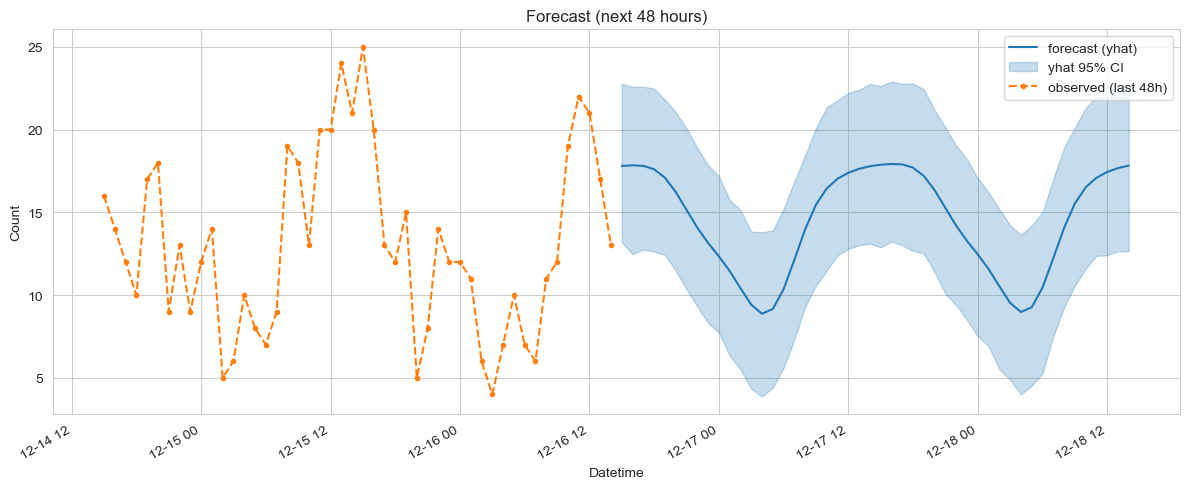

In [89]:
# Plot Prophet forecast for the next 48 hours (with uncertainty) and overlay recent observed hours
next48 = forecast.sort_values('ds').iloc[:48].copy()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(next48['ds'], next48['yhat'], label='forecast (yhat)', color='C0')
ax.fill_between(next48['ds'], next48['yhat_lower'], next48['yhat_upper'], color='C0', alpha=0.25, label='yhat 95% CI')

# overlay the last 48 observed hours if available in df_prophet
if 'df_prophet' in globals() and not df_prophet.empty:
    recent_obs = df_prophet.set_index('ds').last('48H')
    if not recent_obs.empty:
        ax.plot(recent_obs.index, recent_obs['y'], label='observed (last 48h)', color='C1', linestyle='--', marker='o', markersize=3)

ax.set_title('Forecast (next 48 hours)')
ax.set_xlabel('Datetime')
ax.set_ylabel('Count')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Backtest prophet model

In [ ]:
NEW_START_DATE = '2019-01-01' 

df_recent = df_prophet[df_prophet['ds'] >= NEW_START_DATE].copy()

print(f"Data filtered to start from: {NEW_START_DATE}")
print(f"Number of hourly periods now used: {len(df_recent)}")
print(f"Oldest record: {df_recent['ds'].min()}")
print(f"Newest record: {df_recent['ds'].max()}")

# 2. Re-run your train/test split (Backtesting) using df_recent
# Remember to define the CUTOFF_DATE for the backtest (e.g., 1 week ago)
CUTOFF_DATE_BACKTEST = pd.to_datetime('today').floor('H') - pd.Timedelta(weeks=1)

df_train = df_recent[df_recent['ds'] <= CUTOFF_DATE_BACKTEST].copy()
df_test = df_recent[df_recent['ds'] > CUTOFF_DATE_BACKTEST].copy()

Data filtered to start from: 2019-01-01
Number of hourly periods now used: 60999
Oldest record: 2019-01-01 00:00:00
Newest record: 2025-12-16 14:00:00


In [108]:
print("--- Data Split Summary ---")
print(f"Total hourly periods: {len(df_prophet)}")
print(f"Training periods (before {CUTOFF_DATE}): {len(df_train)}")
print(f"Testing periods (after {CUTOFF_DATE}): {len(df_test)}")

# 3. Initialize and Train a NEW Prophet Model on the Training Data
# It's crucial to retrain the model only on the historical data (df_train).
backtest_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive'
)
print("\nFitting new model on Training Data...")
backtest_model.fit(df_train)
print("✅ Backtest model fitting complete.")

# 4. Create the Future Dataframe for the Test Period
# We create a dataframe of the exact timestamps we want to predict (the test set).
future = pd.DataFrame(df_test['ds']).copy()

# 5. Generate the Forecast for the Test Period
forecast = backtest_model.predict(future)

# 6. Merge the actual values (y) with the predicted values (yhat)
results = pd.merge(
    df_test, 
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds', 
    how='inner'
)

# Crucial step: Forecasts can be negative, which is impossible for call counts. 
# We should floor predictions at 0 or a very small positive number.
results['yhat_corrected'] = results['yhat'].clip(lower=0)

--- Data Split Summary ---
Total hourly periods: 193806
Training periods (before 2025-12-09 14:00:00): 60831
Testing periods (after 2025-12-09 14:00:00): 168

Fitting new model on Training Data...


14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing


✅ Backtest model fitting complete.


In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_true = results['y']
y_pred = results['yhat_corrected']

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

print("\n--- Backtest Performance Metrics (Last 7 Days) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} calls/hour")
print(f"Mean Absolute Error (MAE): {mae:.2f} calls/hour")

# MAE is often preferred for count data as it's easier to interpret:
# "On average, our prediction was off by X calls per hour."


--- Backtest Performance Metrics (Last 7 Days) ---
Root Mean Squared Error (RMSE): 3.85 calls/hour
Mean Absolute Error (MAE): 3.10 calls/hour


In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_true = results['y']
y_pred = results['yhat_corrected']

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

print("\n--- Backtest Performance Metrics (Last 7 Days) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} calls/hour")
print(f"Mean Absolute Error (MAE): {mae:.2f} calls/hour")


--- Backtest Performance Metrics (Last 7 Days) ---
Root Mean Squared Error (RMSE): 3.85 calls/hour
Mean Absolute Error (MAE): 3.10 calls/hour


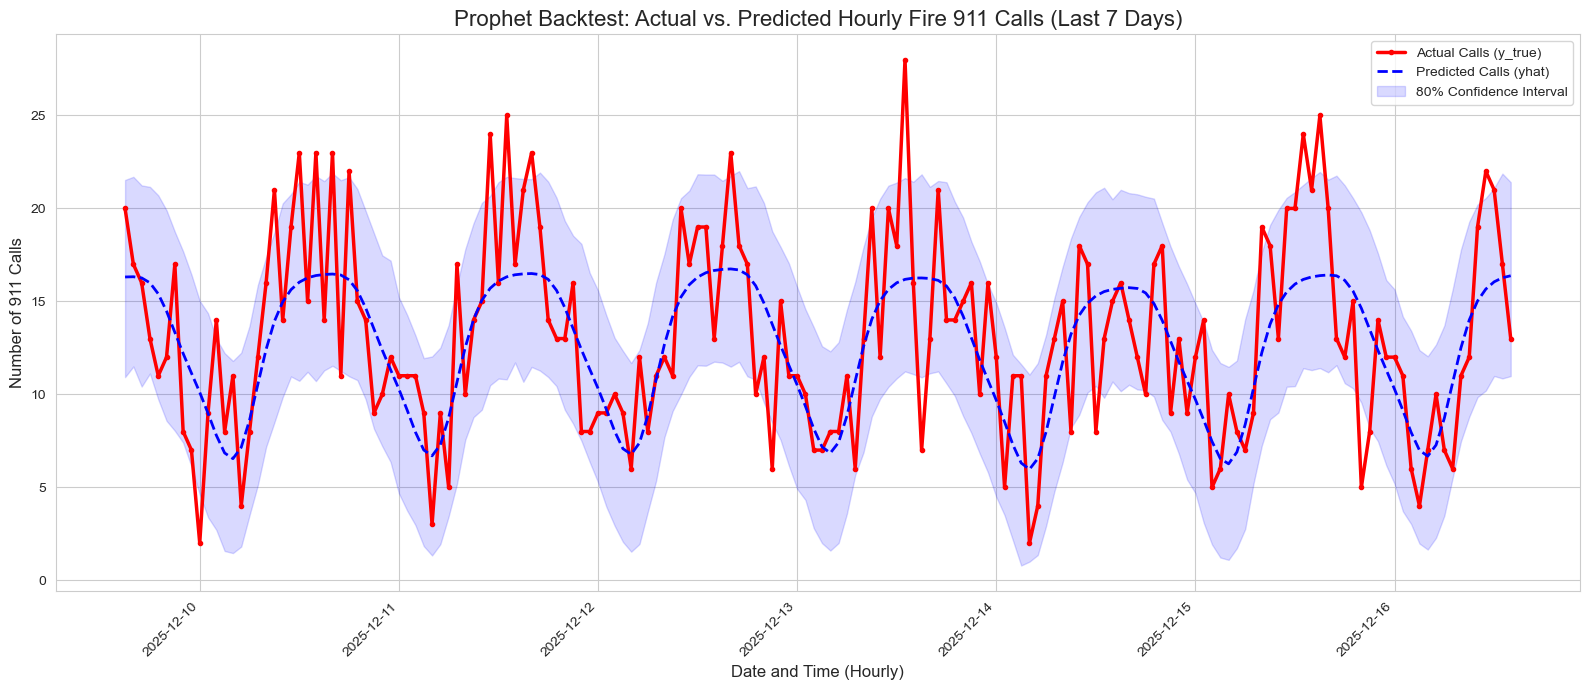

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Assuming 'results' DataFrame is available from the previous step ---
# Re-create a mock 'results' DataFrame for independent demonstration if needed
# Note: You should use your actual 'results' DataFrame generated in the backtest.
if 'results' not in locals():
    print("Creating a mock 'results' DataFrame for visualization...")
    CUTOFF_DATE = pd.to_datetime('2025-12-09 14:00:00') 
    dates = pd.date_range(start=CUTOFF_DATE + pd.Timedelta(hours=1), periods=168, freq='H')
    y_true = np.random.randint(5, 30, size=168) + 5 * np.sin(np.linspace(0, 4*np.pi, 168))
    y_hat = y_true + np.random.normal(0, 3, size=168)
    results = pd.DataFrame({
        'ds': dates, 
        'y': y_true.round().astype(int), 
        'yhat_corrected': y_hat.clip(min=0).round().astype(int),
        'yhat_lower': (y_hat - 5).clip(min=0).round().astype(int),
        'yhat_upper': (y_hat + 5).round().astype(int)
    })
    
# Set a clean visual style
sns.set_style("whitegrid")
plt.figure(figsize=(16, 7))

# 1. Plot the Actual Hourly Call Volume (The ground truth)
plt.plot(
    results['ds'], 
    results['y'], 
    label='Actual Calls (y_true)', 
    color='red', 
    linewidth=2.5, 
    marker='o', 
    markersize=3
)

# 2. Plot the Corrected Predicted Call Volume (The forecast)
plt.plot(
    results['ds'], 
    results['yhat_corrected'], 
    label='Predicted Calls (yhat)', 
    color='blue', 
    linewidth=2, 
    linestyle='--'
)

# 3. Plot the Prediction Confidence Interval (The uncertainty)
plt.fill_between(
    results['ds'], 
    results['yhat_lower'], 
    results['yhat_upper'], 
    color='blue', 
    alpha=0.15, 
    label='80% Confidence Interval'
)

# --- Plot Customization ---
plt.title(f'Prophet Backtest: Actual vs. Predicted Hourly Fire 911 Calls (Last 7 Days)', fontsize=16)
plt.xlabel('Date and Time (Hourly)', fontsize=12)
plt.ylabel('Number of 911 Calls', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Plotting the residuals to tune the model

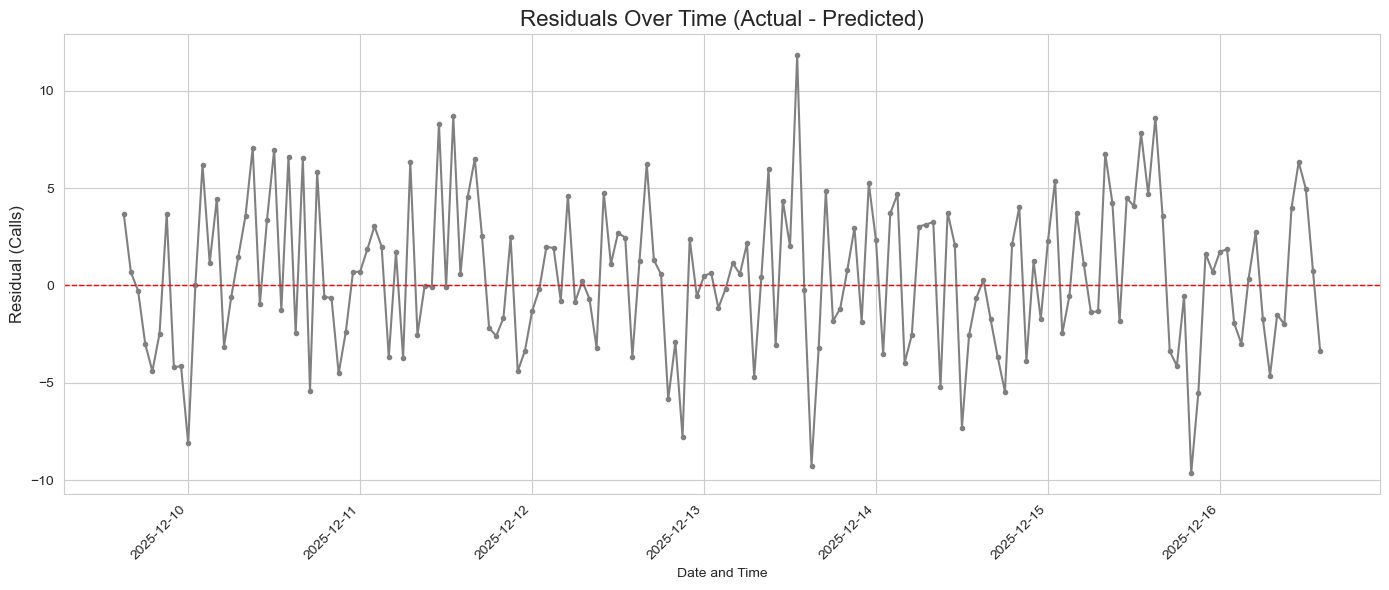

In [112]:
# Assuming 'results' is your backtesting DataFrame
results['Residual'] = results['y'] - results['yhat_corrected']

plt.figure(figsize=(14, 6))
plt.plot(results['ds'], results['Residual'], marker='o', linestyle='-', color='gray', markersize=3)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals Over Time (Actual - Predicted)', fontsize=16)
plt.xlabel('Date and Time')
plt.ylabel('Residual (Calls)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [117]:
backtest_model_2 = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=25.0
)
print("\nFitting new model on Training Data...")
backtest_model_2.fit(df_train)
print("✅ Backtest model fitting complete.")

# 4. Create the Future Dataframe for the Test Period
# We create a dataframe of the exact timestamps we want to predict (the test set).
future = pd.DataFrame(df_test['ds']).copy()

# 5. Generate the Forecast for the Test Period
forecast = backtest_model_2.predict(future)

# 6. Merge the actual values (y) with the predicted values (yhat)
results = pd.merge(
    df_test, 
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds', 
    how='inner'
)

# Crucial step: Forecasts can be negative, which is impossible for call counts. 
# We should floor predictions at 0 or a very small positive number.
results['yhat_corrected'] = results['yhat'].clip(lower=0)


Fitting new model on Training Data...


14:57:33 - cmdstanpy - INFO - Chain [1] start processing
14:57:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Backtest model fitting complete.


In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_true = results['y']
y_pred = results['yhat_corrected']

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

print("\n--- Backtest Performance Metrics (Last 7 Days) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} calls/hour")
print(f"Mean Absolute Error (MAE): {mae:.2f} calls/hour")

# MAE is often preferred for count data as it's easier to interpret:
# "On average, our prediction was off by X calls per hour."


--- Backtest Performance Metrics (Last 7 Days) ---
Root Mean Squared Error (RMSE): 3.84 calls/hour
Mean Absolute Error (MAE): 3.09 calls/hour


## Identify top volume hours for regressor

In [126]:
# Find the hour of day from the 'ds' column
df_train['hour'] = df_train['ds'].dt.hour 

# Create the binary flag: 1 if it's a known peak hour (e.g., 16-20), 0 otherwise
PEAK_HOURS = [13,14,15,16,17,18]
df_train['peak_hour_flag'] = df_train['hour'].apply(lambda x: 1 if x in PEAK_HOURS else 0)

# The future DataFrame for prediction must also have this column!
# future['hour'] = future['ds'].dt.hour
# future['peak_hour_flag'] = future['hour'].apply(lambda x: 1 if x in PEAK_HOURS else 0)

In [137]:
tuned_model_regressor = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

# Add the binary indicator for peak hours
tuned_model_regressor.add_regressor('peak_hour_flag') # <--- Add the new feature

# Fit using the DataFrame that now contains 'peak_hour_flag'
tuned_model_regressor.fit(df_train)
# ... run backtest (making sure 'peak_hour_flag' is in the 'future' DataFrame) ...

future = pd.DataFrame(df_test['ds']).copy()
future['hour'] = future['ds'].dt.hour
future['peak_hour_flag'] = future['hour'].apply(lambda x: 1 if x in PEAK_HOURS else 0)

# 5. Generate the Forecast for the Test Period
forecast = tuned_model_regressor.predict(future)

# 6. Merge the actual values (y) with the predicted values (yhat)
results = pd.merge(
    df_test, 
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds', 
    how='inner'
)

# Crucial step: Forecasts can be negative, which is impossible for call counts. 
# We should floor predictions at 0 or a very small positive number.
results['yhat_corrected'] = results['yhat'].clip(lower=0)

15:12:08 - cmdstanpy - INFO - Chain [1] start processing
15:12:16 - cmdstanpy - INFO - Chain [1] done processing


In [138]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_true = results['y']
y_pred = results['yhat_corrected']

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

print("\n--- Backtest Performance Metrics (Last 7 Days) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} calls/hour")
print(f"Mean Absolute Error (MAE): {mae:.2f} calls/hour")

# MAE is often preferred for count data as it's easier to interpret:
# "On average, our prediction was off by X calls per hour."


--- Backtest Performance Metrics (Last 7 Days) ---
Root Mean Squared Error (RMSE): 3.84 calls/hour
Mean Absolute Error (MAE): 3.09 calls/hour


# Adding additional Data